In [1]:
import dihz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The dihz started successfully.


## 斯特潘—玻尔兹曼常数
$\sigma=5.66956*10^{-12} J cm^{-2}K^{-4}s^{-1}$

## 恒星质量与半径，有效温度线性拟合系数
$R = a*M+b$    
$T = a*M+b$

In [2]:
#Determine habitability
def determine_hb(a,b,c,d):
    
    if a>c and b<d:
        return 1 #liveable
    elif a>d or b<c:
        return 2 #unliveable
    else:
        return 0 #part livable

In [3]:
def circumbinary2D(a_p, min_dis, max_dis, hzi, hzo,
                   a_b=0.1,xmin=-2, xmax=2, ymin=-2, ymax=2, title='',hz_type=''):
    """Plot the circumbinary dynamically informed habitable zones.
    
    parameters:
    -----------
    a_p      ...  The semimajor axis of the planet's initial orbit
    min_dis  ...  The shortest radius of a planet's orbit
    max_dis  ...  The longest radius of a planet's orbit
    hzi      ...  The inner boundary of the habitable zone
    hzo      ...  The outer boundary of the habitable zone
    a_b      ...  Initial distance of binary star
    
    Returns:
    -------
    matplotlib pyplot plot
    """
    
    xs = np.linspace(xmin, xmax, 2000)
    ys = np.linspace(ymin, ymax, 2000)
    
    #mesh for contours
    xv,yv = np.meshgrid(xs, ys)
    
    # generate the level map
    r = np.sqrt(xv**2 + yv**2)
    
    print('Orbital Range',min_dis, max_dis)
    print('Habitable Zone', hzi, hzo)
    
    plt.figure(figsize=(4,4), dpi=200)
    plt.title(title)
    #plot the contours
    plt.contourf(xs,ys,r,levels=[0,a_b], colors='r')#star
    plt.contourf(xs,ys,r, levels=[min_dis,max_dis], colors=('#ac10e0'))#planet's orbit
    plt.contour(xs,ys,r, levels=[hzi,hzo], colors=('#EEA700'))#habitable zone
    
    #plot the two circles
    plt.contour(xs,ys,r, levels=[min_dis], colors='k',linewidths=0.6)
    plt.contour(xs,ys,r, levels=[max_dis], colors='k',linewidths=0.6)
    
    #plot the planet
    plt.scatter(a_p, 0, color='b', s=15, facecolor='black', zorder=3)
    
    
    plt.text(0,0,'AB', horizontalalignment='center',verticalalignment='center')
    plt.text(xmin+0.5,ymax-0.3,hz_type,horizontalalignment='left',verticalalignment='center',color='#EEA700')
    plt.text(xmin+0.5,ymax-0.6,'Planet Orbital Range',horizontalalignment='left',verticalalignment='center',color='#ac10e0')
    
    plt.xlabel('x [au]')
    plt.ylabel('y [au]')

In [4]:
#data loading
file = 'data.csv'
df = pd.read_csv(file, sep=' ', header=None, names=['m2', 'e_b', 'a_p', 'inc', 'status', 'min_dis', 'max_dis'])

In [5]:
#processing data

#add m1
m1 = df['m2'].apply(lambda x: 1-x)
df.insert(0,'m1', m1)

#for R: a=1.24; b=-0.09
r1 = df['m1'].apply(lambda x:1.24*x-0.09)
r2 = df['m2'].apply(lambda x:1.24*x-0.09)
df.insert(2,'r2', r2)
df.insert(2,'r1', r1)

#for T: a=2879.14; b=2658.15
t1 = df['m1'].apply(lambda x:2879.14*x+2658.15)
t2 = df['m2'].apply(lambda x:2879.14*x+2658.15)
df.insert(4,'t2',t2)
df.insert(4,'t1',t1)

In [6]:
#Screening stable sample
stable=df[df['status']==1]
L1=stable.apply(lambda x: x['r1']**(2) * (x['t1']/5800.)**(4), axis=1)
L2=stable.apply(lambda x: x['r2']**(2) * (x['t2']/5800.)**(4), axis=1)
stable.insert(6,'L2',L2)
stable.insert(6,'L1',L1)
stable.head(5)

,m1,m2,r1,r2,t1,t2,L1,L2,e_b,a_p,inc,status,min_dis,max_dis
1,0.76,0.24,0.8524,0.2076,4846.2964,3349.1436,0.354172,0.004792,0.05,0.65,2.792527,1,0.566617,0.729291
2,0.74,0.26,0.8276,0.2324,4788.7136,3406.7264,0.318276,0.006428,0.01,0.85,2.617994,1,0.772926,0.924140
3,0.77,0.23,0.8648,0.1952,4875.0878,3320.3522,0.373292,0.004092,0.52,1.01,2.617994,1,0.888109,1.126331
4,0.68,0.32,0.7532,0.3068,4615.9652,3579.4748,0.227593,0.013655,0.45,0.98,1.919862,1,0.876199,1.078768
5,0.65,0.35,0.7160,0.3440,4529.5910,3665.8490,0.190700,0.018884,0.34,1.07,1.221730,1,0.979342,1.136921


In [7]:
#Calculating the habitable zone
M1 = stable[['m1', 'r1', 't1','L1','e_b']].to_dict('list')
M2 = stable[['m2', 'r2', 't2', 'L2']].to_dict('list')
ab = 0.1
num = len(stable['m1'])
phzi = np.zeros(num)
phzo = np.zeros(num)
ahzi = np.zeros(num)
ahzo = np.zeros(num)
for i in range(num):
    [PHZI,PHZO]=dihz.circumbinary.PHZ(M1['L1'][i],M1['t1'][i],M1['m1'][i],M2['L2'][i],M2['t2'][i],M2['m2'][i],ab,M1['e_b'][i])
    [AHZI,AHZO]=dihz.circumbinary.AHZ(M1['L1'][i],M1['t1'][i],M1['m1'][i],M2['L2'][i],M2['t2'][i],M2['m2'][i],ab,M1['e_b'][i])
    phzi[i] = PHZI 
    phzo[i] = PHZO
    ahzi[i] = AHZI
    ahzo[i] = AHZO
n = len(stable.loc[1,:])
stable.insert(n, 'phzo', phzo)
stable.insert(n, 'phzi', phzi)
stable.insert(n, 'ahzo', ahzo)
stable.insert(n, 'ahzi', ahzi)

In [8]:
#reset index
stable = stable.reset_index(drop=True)
stable['phb'] = stable.apply(lambda x: determine_hb(x.min_dis, x.max_dis, x.phzi, x.phzo), axis=1)
ahb = stable.apply(lambda x: determine_hb(x.min_dis, x.max_dis, x.ahzi, x.ahzo), axis=1)
stable.insert(16,'ahb',ahb)
stable.head(10)

,m1,m2,r1,r2,t1,t2,L1,L2,e_b,a_p,inc,status,min_dis,max_dis,ahzi,ahzo,ahb,phzi,phzo,phb
0,0.76,0.24,0.8524,0.2076,4846.2964,3349.1436,0.354172,0.004792,0.05,0.65,2.792527,1,0.566617,0.729291,0.598839,1.091650,0,0.657071,1.040553,0
1,0.74,0.26,0.8276,0.2324,4788.7136,3406.7264,0.318276,0.006428,0.01,0.85,2.617994,1,0.772926,0.924140,0.571071,1.043996,1,0.624958,0.997532,1
2,0.77,0.23,0.8648,0.1952,4875.0878,3320.3522,0.373292,0.004092,0.52,1.01,2.617994,1,0.888109,1.126331,0.613184,1.116260,0,0.761138,1.000343,0
3,0.68,0.32,0.7532,0.3068,4615.9652,3579.4748,0.227593,0.013655,0.45,0.98,1.919862,1,0.876199,1.078768,0.496055,0.915282,0,0.634138,0.818085,2
4,0.65,0.35,0.7160,0.3440,4529.5910,3665.8490,0.190700,0.018884,0.34,1.07,1.221730,1,0.979342,1.136921,0.464039,0.860424,2,0.580891,0.781819,2
5,0.78,0.22,0.8772,0.1828,4903.8792,3291.5608,0.393228,0.003466,0.50,1.13,0.698132,1,1.016448,1.239030,0.627816,1.141360,0,0.771292,1.027451,0
6,0.54,0.46,0.5796,0.4804,4212.8856,3982.5544,0.093511,0.051303,0.21,1.15,1.396263,1,1.082631,1.214583,0.389634,0.733366,2,0.447762,0.720206,2
7,0.52,0.48,0.5548,0.5052,4155.3028,4040.1372,0.081091,0.060090,0.17,1.27,1.047198,1,1.207828,1.330221,0.385014,0.725495,2,0.426851,0.726228,2
8,0.79,0.21,0.8896,0.1704,4932.6706,3262.7694,0.414005,0.002908,0.20,1.00,0.698132,1,0.904397,1.094444,0.642727,1.166935,1,0.726542,1.094066,0
9,0.51,0.49,0.5424,0.5176,4126.5114,4068.9286,0.075381,0.064893,0.12,0.80,0.523599,1,0.739823,0.856690,0.383857,0.723519,2,0.415881,0.730355,2


Orbital Range 0.7729262642048402 0.924139517207964
Habitable Zone 0.624958459908611 0.9975321901167126


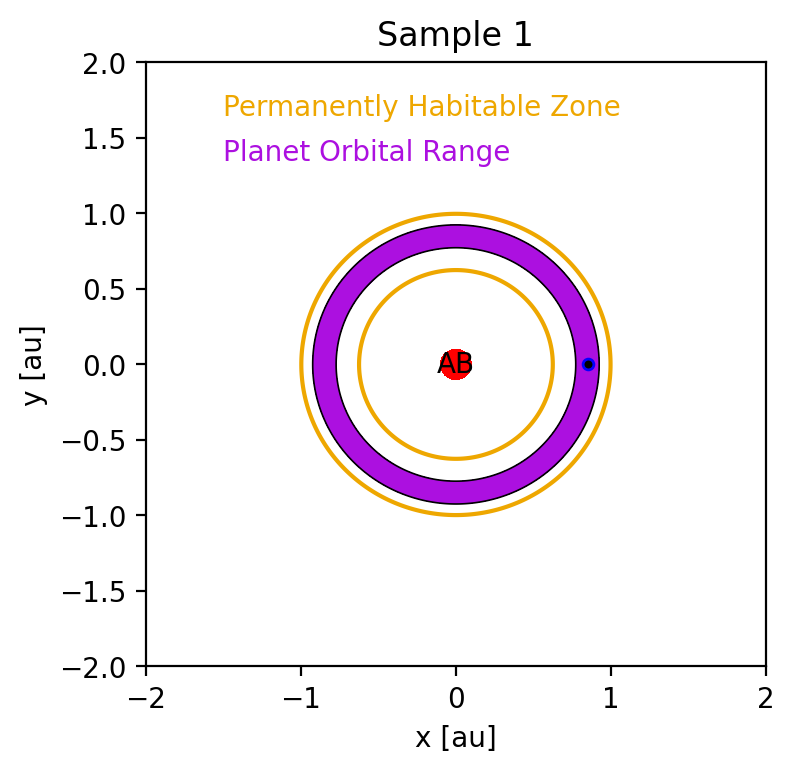

In [9]:
#sample 1
F1 = stable[['a_p','min_dis','max_dis','phzi','phzo']].loc[1]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 1',hz_type='Permanently Habitable Zone')

Orbital Range 0.7729262642048402 0.924139517207964
Habitable Zone 0.5710706453720285 1.0439958101764275


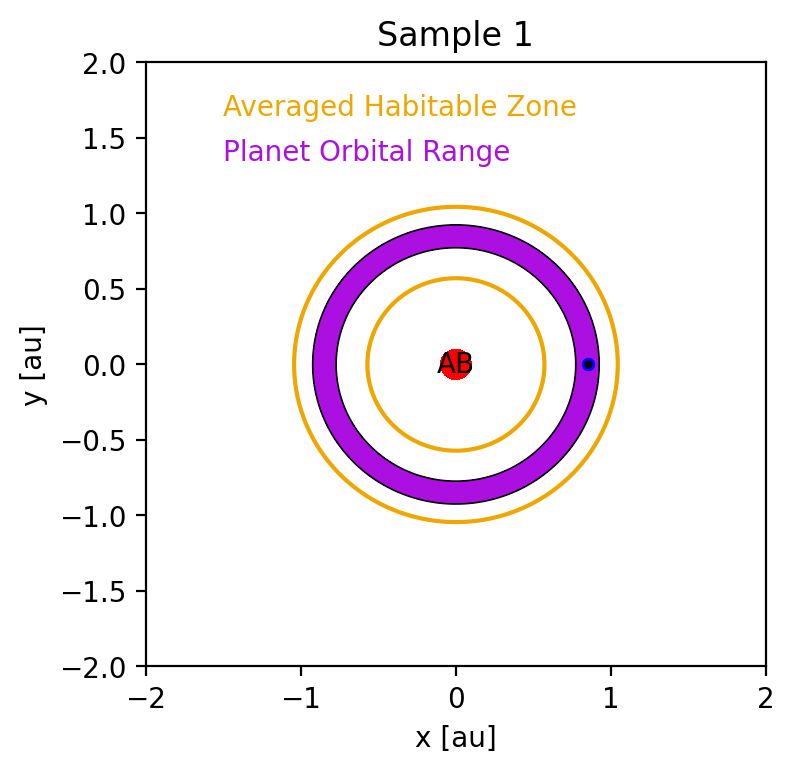

In [10]:
#sample 1
F1 = stable[['a_p','min_dis','max_dis','ahzi','ahzo']].loc[1]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 1',hz_type='Averaged Habitable Zone')

Orbital Range 0.8881091765941953 1.1263308218323949
Habitable Zone 0.7611384882476877 1.0003426920438938


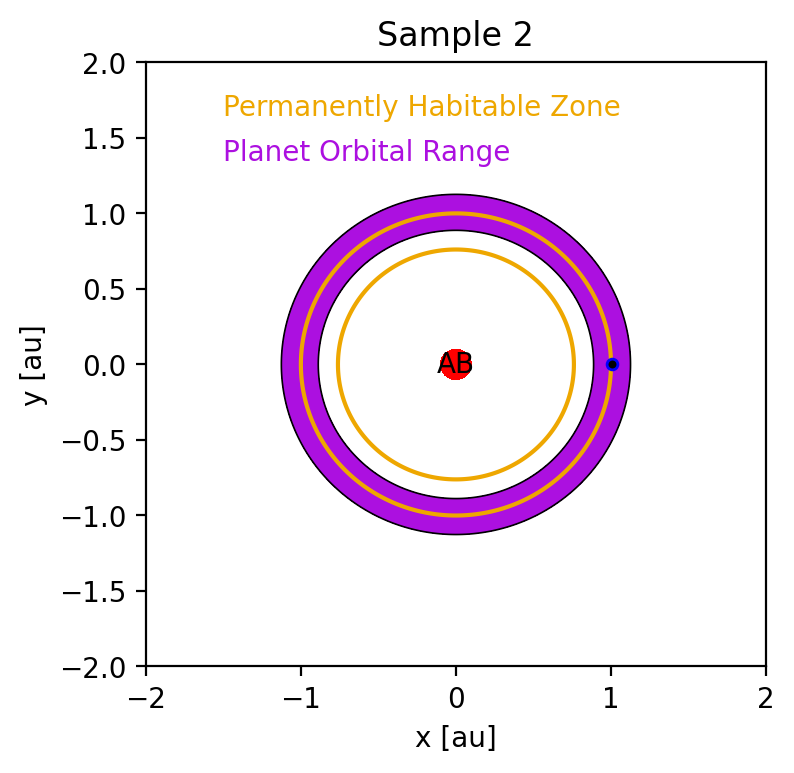

In [11]:
#sample 2
F1 = stable[['a_p','min_dis','max_dis','phzi','phzo']].loc[2]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 2',hz_type='Permanently Habitable Zone')

Orbital Range 0.8881091765941953 1.1263308218323949
Habitable Zone 0.6131839554037806 1.1162598150188847


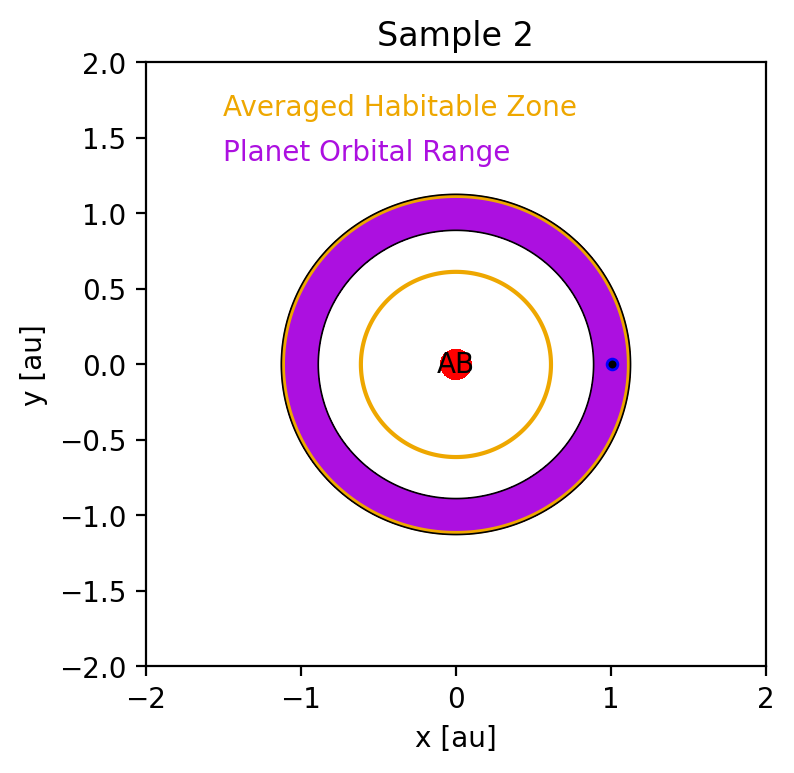

In [12]:
#sample 2
F1 = stable[['a_p','min_dis','max_dis','ahzi','ahzo']].loc[2]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 2',hz_type='Averaged Habitable Zone')

Orbital Range 0.876198940594015 1.0787679922633393
Habitable Zone 0.6341375779542924 0.8180848370313122


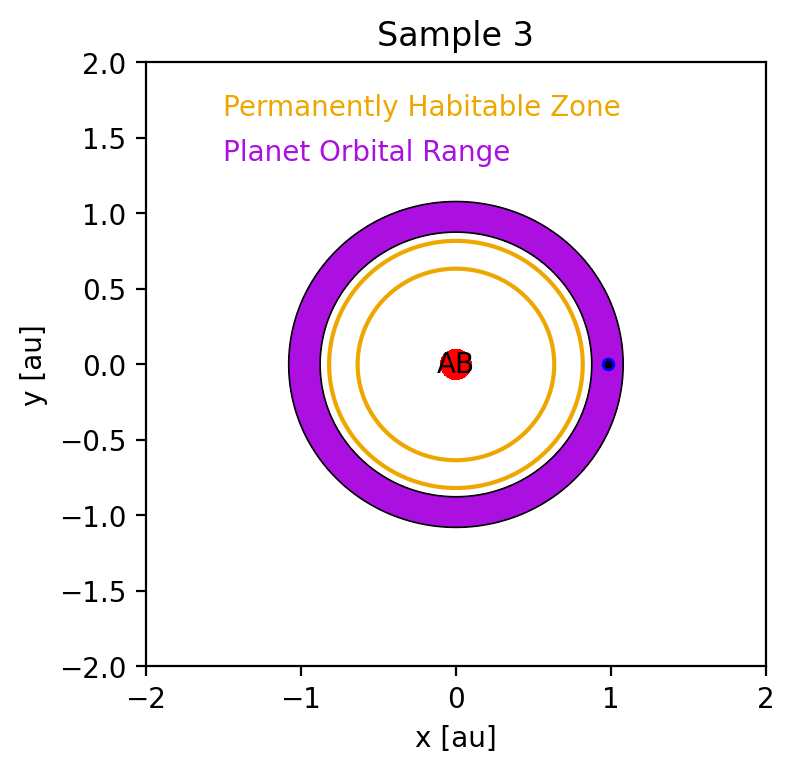

In [13]:
#sample 3
F1 = stable[['a_p','min_dis','max_dis','phzi','phzo']].loc[3]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 3',hz_type='Permanently Habitable Zone')

Orbital Range 0.876198940594015 1.0787679922633393
Habitable Zone 0.49605458945033115 0.9152815016147576


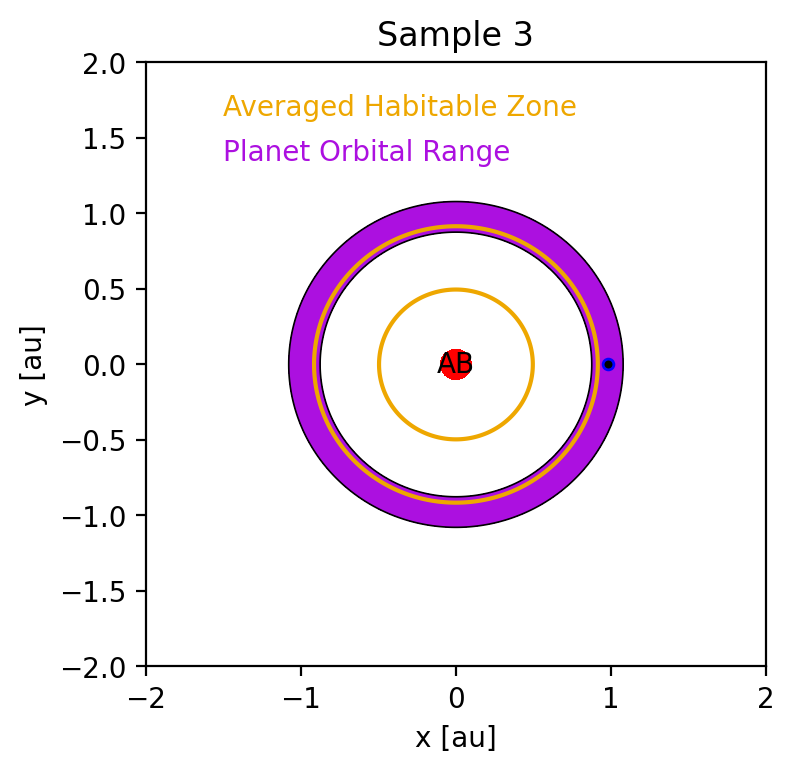

In [14]:
#sample 3
F1 = stable[['a_p','min_dis','max_dis','ahzi','ahzo']].loc[3]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 3',hz_type='Averaged Habitable Zone')

Orbital Range 0.9793423035918488 1.1369206219176398
Habitable Zone 0.5808912679765186 0.7818193281776851


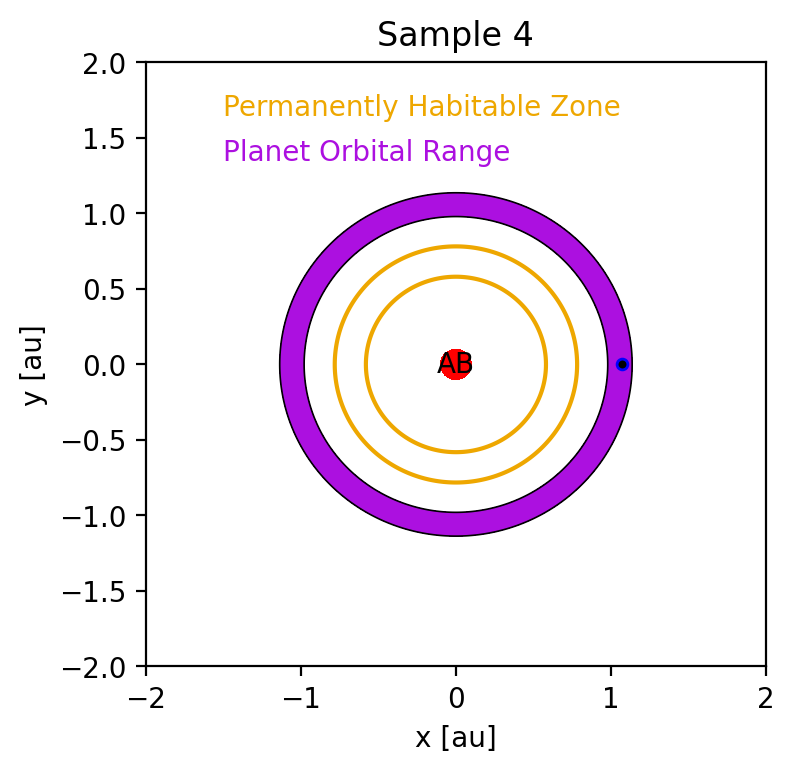

In [15]:
#sample 4
F1 = stable[['a_p','min_dis','max_dis','phzi','phzo']].loc[4]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 4',hz_type='Permanently Habitable Zone')

Orbital Range 0.9793423035918488 1.1369206219176398
Habitable Zone 0.46403858144489935 0.8604242549181376


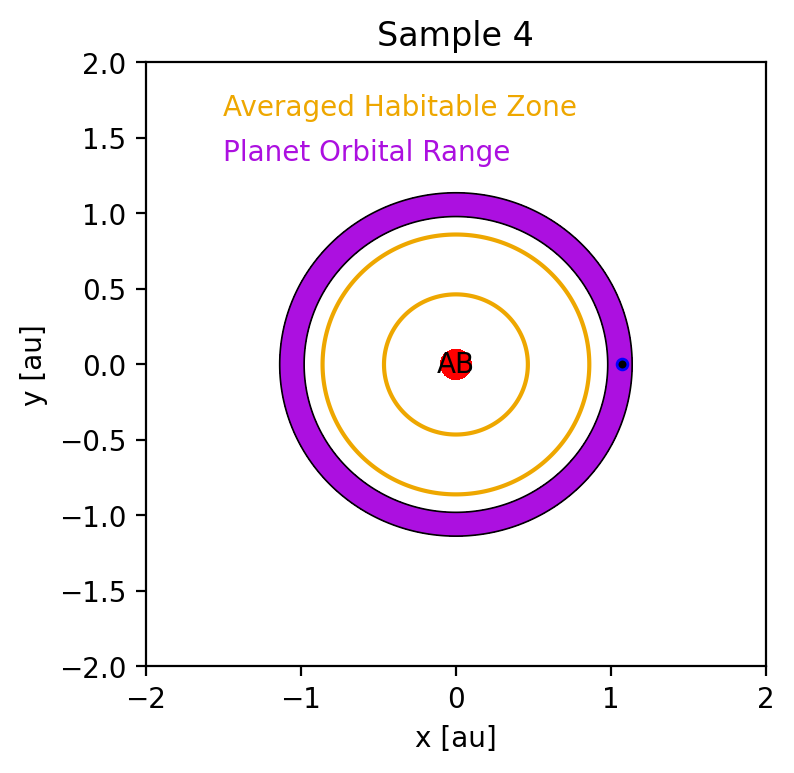

In [16]:
#sample 4
F1 = stable[['a_p','min_dis','max_dis','ahzi','ahzo']].loc[4]
F = circumbinary2D(F1[0],F1[1],F1[2],F1[3],F1[4],title='Sample 4',hz_type='Averaged Habitable Zone')